# Explore and Cluster the Neighborhoods in TORONTO

## **Part I**

#### In this part, the BeautifulSoup package will be used to transform the data in the table on the Wikipedia page into the pandas dataframe required. 

##### 1.Import Libraries

In [7]:
import numpy as np # data in a vectorized manner manipulation
import pandas as pd # data analsysis
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # JSON files manipulation
import requests # HTTP library
from bs4 import BeautifulSoup # scraping library

from sklearn.cluster import KMeans # clustering algorithm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


##### 2.Extract data of Toronto neighborhoods from Wikipedia

In [8]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

text_result = requests.get(url).text #get the entire html of the article as a str
html_parsed_result = BeautifulSoup(text_result, 'html.parser') #transform the text to html

neightborhood_info_table = html_parsed_result.find('table', class_ = 'wikitable')
neightborhood_rows = neightborhood_info_table.find_all('tr')

# extract the info ('Postcode', 'Borough', 'Neighbourhood') from the table
neightborhood_info = []
for row in neightborhood_rows:
    info = row.text.split('\n')[1:-1] # remove empty str (first and last items)
    neightborhood_info.append(info)
    
neightborhood_info[0:10]

[['Postcode', 'Borough', 'Neighbourhood'],
 ['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village'],
 ['M5A', 'Downtown Toronto', 'Harbourfront'],
 ['M5A', 'Downtown Toronto', 'Regent Park'],
 ['M6A', 'North York', 'Lawrence Heights'],
 ['M6A', 'North York', 'Lawrence Manor'],
 ['M7A', "Queen's Park", 'Not assigned']]

##### 3.Clean and Transform the data into a pandas dataframe

In [9]:
neightborhood_info[0][-1] = 'Neighborhood' # change to american spelling
neighborhood_df = pd.DataFrame(neightborhood_info[1:], columns=neightborhood_info[0])

neighborhood_df.head(10)

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned


In [10]:
not_assigned_boroughs = neighborhood_df.index[neighborhood_df['Borough'] == 'Not assigned']
not_assigned_neighborhoods = neighborhood_df.index[neighborhood_df['Neighborhood'] == 'Not assigned']
not_assigned_neighborhoods_and_borough = not_assigned_boroughs & not_assigned_neighborhoods
neighborhood_df.drop(neighborhood_df.index[not_assigned_boroughs], inplace=True)
neighborhood_df.reset_index(drop=True, inplace=True)
not_assigned_neighborhoods = neighborhood_df.index[neighborhood_df['Neighborhood'] == 'Not assigned'] # run this again because the indexes on the dataframe where reset

for idx in not_assigned_neighborhoods:
    neighborhood_df['Neighborhood'][idx] = neighborhood_df['Borough'][idx]

group = neighborhood_df.groupby('Postcode')
grouped_neighborhoods = group['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
grouped_boroughs = group['Borough'].apply(lambda x: set(x).pop())
final_df = pd.DataFrame(list(zip(grouped_boroughs.index, grouped_boroughs, grouped_neighborhoods)))
final_df.columns = ['Postcode', 'Borough', 'Neighborhood']

final_df.head(12)

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [11]:
print('The Final DataFrame shape is', final_df.shape)

The Final DataFrame shape is (103, 3)


## ** This is the end of Part I **

## **Part II**

#### In this part, the Final Dataframe created above will be added two new columns named 'Latitude' and 'Longtitude'

In [12]:
geo_df = pd.read_csv('https://cocl.us/Geospatial_data') 

geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [13]:
dataframe_with_coordinates_df = final_df.join(geo_df.set_index('Postal Code'), on='Postcode')

dataframe_with_coordinates_df.head(16)

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


## ** This is the end of Part II **

## **Part III**

#### 1. Draw a raw map

In [14]:
map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in dataframe_with_coordinates_df.itertuples(): 
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-2], location[-1]],
        radius=1,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=500,
        popup=label,
        location=[location[-2], location[-1]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map

##### The map above shows that the Postal codes are not evenly spaced, so some of the areas are covered by the others of them. Consequently, the following scatter plots will show a much more clear version of map.

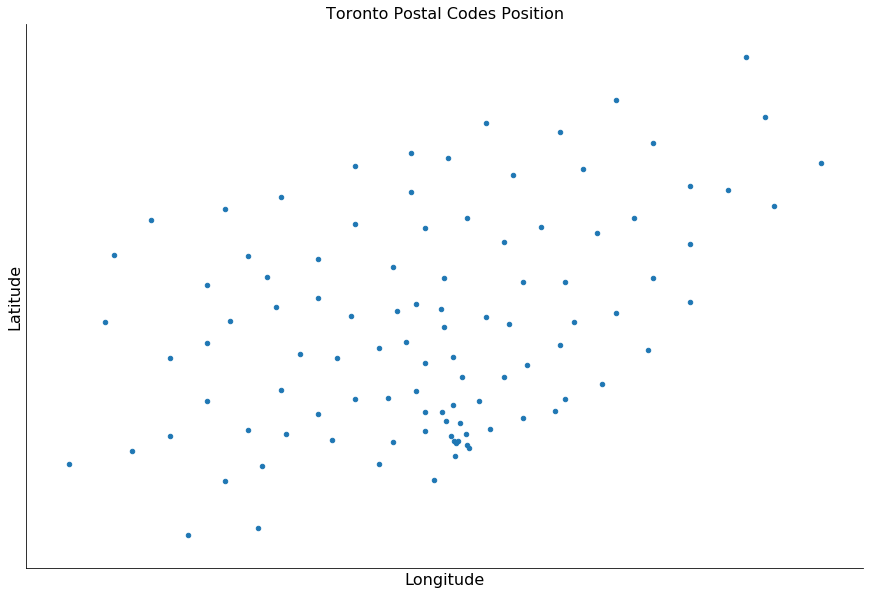

In [16]:
import matplotlib.pyplot as plt

X = dataframe_with_coordinates_df[['Longitude', 'Latitude']]

scatter_plot = X.plot.scatter(x='Longitude', 
               y='Latitude',  
               fontsize = 16,
               figsize=(15, 10))

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
scatter_plot.set_title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

##### The Distance column will be added to the dataframe to avoid overlapping.

In [19]:
pip install geopy

     |████████████████████████████████| 102kB 4.9MB/s 
  Stored in directory: /home/jovyan/.cache/pip/wheels/99/45/d1/14954797e2a976083182c2e7da9b4e924509e59b6e5c661061
Successfully built geographiclib
Note: you may need to restart the kernel to use updated packages.


In [20]:
from geopy.distance import great_circle

#function to get the closest postcode pair and the distance using latitude and longitude
def closest_postcode(postcode, postcodes):
    postcode = np.asarray(postcode).reshape(1,-1)
    postcodes = np.asarray(postcodes)
    distances = [great_circle(postcode, point).meters for point in postcodes]
    closest_postcode_index = np.argmin(distances)
    return [round(distances[closest_postcode_index]), closest_postcode_index]

In [23]:
coordinates = dataframe_with_coordinates_df[['Latitude', 'Longitude']]

distance, closest_point_index = closest_postcode(coordinates[:1], coordinates[~coordinates.index.isin([0])])
close_points = X[:1].append(X[closest_point_index+1:closest_point_index+2])
close_points

,Longitude,Latitude
0,-79.194353,43.806686
16,-79.205636,43.836125


In [24]:
from math import isnan

for lat, lng, idx in zip(dataframe_with_coordinates_df['Latitude'], dataframe_with_coordinates_df['Longitude'], dataframe_with_coordinates_df.index):
    distance, closest_point_index = closest_postcode([lat,lng], coordinates[~coordinates.index.isin([idx])])
    dataframe_with_coordinates_df.at[idx,'Distance'] = np.int64(distance//2) #use the half of the disstance to avoid overlapping
    
dataframe_with_coordinates_df.head(15)

,Postcode,Borough,Neighborhood,Latitude,Longitude,Distance
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1698.0
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1625.0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1205.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,913.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,913.0
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,1301.0
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,1112.0
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,1052.0
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,1112.0
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,1297.0


#### 2. Draw a map without overslapping

In [26]:
map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in dataframe_with_coordinates_df.itertuples(): #iterate each row of the dataframe
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-3], location[-2]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=location[-1],
        popup=label,
        location=[location[-3], location[-2]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map

#### 3. Get venues

##### Use Foursquare to get venues

In [28]:
CLIENT_ID = 'DK5OAI2HHKUBZ0RCYJZSIXH02GS2LMNV4VHC5L1JHXWDS1OD' 
CLIENT_SECRET = 'CY0UD5NOYPVXX21SFLAEI0K5AZZVVWHUTJVCEQBGQEG0RSVF' 
VERSION = '20180605' 

print('Ready to go')

Ready to go


##### To explore the data returned by the Foursquare API, a maximum of 100 venues from the third postcode are requested in a radius of 500 meters.

In [31]:
def format_url(lat, lng, radius=500, limit=100):
    return 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, 
        lat, lng, VERSION, radius, limit)

third_postcode = dataframe_with_coordinates_df.iloc[4, :]
url = format_url(third_postcode['Latitude'], third_postcode['Longitude'], third_postcode['Distance'])

url

'https://api.foursquare.com/v2/venues/explore?client_id=DK5OAI2HHKUBZ0RCYJZSIXH02GS2LMNV4VHC5L1JHXWDS1OD&client_secret=CY0UD5NOYPVXX21SFLAEI0K5AZZVVWHUTJVCEQBGQEG0RSVF&ll=43.773136,-79.23947609999999&v=20180605&radius=913.0&limit=100'

In [33]:
def get_venues(url):
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    return json_normalize(venues)

venues_df = get_venues(url)

venues_df.head()

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,venue.location.distance,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4b1711a6f964a520cbc123e3-0,"[{'id': '52af3ac83cf9994f4e043bf3', 'name': 'H...",4b1711a6f964a520cbc123e3,1920 Ellesmere Rd,CA,Scarborough,Canada,at Bellamy Rd. N,219,"[1920 Ellesmere Rd (at Bellamy Rd. N), Scarbor...","[{'label': 'display', 'lat': 43.77469659057996...",43.774697,-79.241142,M1H 2V6,ON,Federick Restaurant,0,[]
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4d6008f829ef236a8832a059-1,"[{'id': '4bf58dd8d48988d10f941735', 'name': 'I...",4d6008f829ef236a8832a059,1760 Ellesmere Rd.,CA,Scarborough,Canada,NaN,532,"[1760 Ellesmere Rd., Scarborough ON M1H 2V5, C...","[{'label': 'display', 'lat': 43.77354633117736...",43.773546,-79.246082,M1H 2V5,ON,CANBE Foods Inc,0,[]
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4e261f261f6eb1ae13930699-2,"[{'id': '4bf58dd8d48988d144941735', 'name': 'C...",4e261f261f6eb1ae13930699,1085 Bellamy Rd N,CA,Scarborough,Canada,Bellamy & Ellesmere,291,"[1085 Bellamy Rd N (Bellamy & Ellesmere), Scar...","[{'label': 'display', 'lat': 43.77522213879153...",43.775222,-79.241678,NaN,ON,Drupati's Roti & Doubles,0,[]
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4bf470256a31d13a9ec7952e-3,"[{'id': '4bf58dd8d48988d16c941735', 'name': 'B...",4bf470256a31d13a9ec7952e,1021 Markham Road,CA,Toronto,Canada,Brimorton,729,"[1021 Markham Road (Brimorton), Toronto ON M1K...","[{'label': 'display', 'lat': 43.77408136872742...",43.774081,-79.230496,M1K 2Y5,ON,The Real McCoy Burgers And Pizza,0,[]
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4c4b8f0e9c8d2d7f5955196b-4,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",4c4b8f0e9c8d2d7f5955196b,1150 Markham Rd,CA,Scarborough,Canada,at Ellesmere Rd.,670,"[1150 Markham Rd (at Ellesmere Rd.), Scarborou...","[{'label': 'display', 'lat': 43.77599190613985...",43.775992,-79.232135,M1H 2Y6,ON,Tim Hortons,0,[]


##### Now we need to clean this dataframe since it contains many irrelavant statistics.

In [34]:
def clean_df(df):
    relevant_columns = ['venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.name']
    clean_df = df.loc[:,relevant_columns]

    #rename columns
    clean_df.columns = ['Category', 'Lat', 'Lng', 'Name']
    return clean_df 

venues_df = clean_df(venues_df)
venues_df.head()

,Category,Lat,Lng,Name
0,"[{'id': '52af3ac83cf9994f4e043bf3', 'name': 'H...",43.774697,-79.241142,Federick Restaurant
1,"[{'id': '4bf58dd8d48988d10f941735', 'name': 'I...",43.773546,-79.246082,CANBE Foods Inc
2,"[{'id': '4bf58dd8d48988d144941735', 'name': 'C...",43.775222,-79.241678,Drupati's Roti & Doubles
3,"[{'id': '4bf58dd8d48988d16c941735', 'name': 'B...",43.774081,-79.230496,The Real McCoy Burgers And Pizza
4,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.775992,-79.232135,Tim Hortons


In [35]:
venues_df.loc[0, 'Category']

[{'id': '52af3ac83cf9994f4e043bf3',
  'name': 'Hakka Restaurant',
  'pluralName': 'Hakka Restaurants',
  'shortName': 'Hakka',
  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',
   'suffix': '.png'},
  'primary': True}]

##### It is necessary to extract the Category (shortName) of the JSON data.

In [36]:
#function that extract the category name
def get_category_name(row):
    category_json = row['Category']
    try:
        return category_json[0]['name']
    except:        
        return None

venues_df['Category'] = venues_df.apply(get_category_name, axis=1)

venues_df

,Category,Lat,Lng,Name
0,Hakka Restaurant,43.774697,-79.241142,Federick Restaurant
1,Indian Restaurant,43.773546,-79.246082,CANBE Foods Inc
2,Caribbean Restaurant,43.775222,-79.241678,Drupati's Roti & Doubles
3,Burger Joint,43.774081,-79.230496,The Real McCoy Burgers And Pizza
4,Coffee Shop,43.775992,-79.232135,Tim Hortons
5,Thai Restaurant,43.774468,-79.241268,Thai One On
6,Chinese Restaurant,43.776309,-79.234939,Hakka Legend
7,Indian Restaurant,43.776214,-79.234848,La Sani Grill
8,Athletics & Sports,43.774593,-79.236500,Centennial Recreation Centre
9,Music Store,43.775903,-79.230965,Long & McQuade


##### Next step is to get venues for each postal code.

In [37]:
#function to construct the dataframe with all the venues (max 100 venues per postal code)
def get_all_venues(postcodes, lat, lng, radius):
    venues_list=[]
    for postcode, lat, lng, radius in zip(postcodes, lat, lng, radius):
        url= format_url(lat, lng, radius)
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(
            postcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name'])
            for v in results])
    all_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    all_venues.columns = ['Postcode', 
                  'Postcode Latitude', 
                  'Postcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category'
                  ]
    
    return all_venues

In [40]:
all_venues = get_all_venues(dataframe_with_coordinates_df['Postcode'], dataframe_with_coordinates_df['Latitude'], dataframe_with_coordinates_df['Longitude'], dataframe_with_coordinates_df['Distance'])

print('The total number of venues returned is ', all_venues.shape[0])

all_venues.head(10)

The total number of venues returned is  3325


,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,43.806686,-79.194353,African Rainforest Pavilion,43.817725,-79.183433,Zoo Exhibit
1,M1B,43.806686,-79.194353,Canadiana exhibit,43.817962,-79.193374,Zoo Exhibit
2,M1B,43.806686,-79.194353,Images Salon & Spa,43.802283,-79.198565,Spa
3,M1B,43.806686,-79.194353,penguin exhibit,43.819435,-79.185959,Zoo Exhibit
4,M1B,43.806686,-79.194353,Lion Exhibit,43.819228,-79.186977,Zoo Exhibit
5,M1B,43.806686,-79.194353,Orangutan Exhibit,43.818413,-79.182548,Zoo Exhibit
6,M1B,43.806686,-79.194353,Gorilla Exhibit,43.819080,-79.184235,Zoo Exhibit
7,M1B,43.806686,-79.194353,Caribbean Wave,43.798558,-79.195777,Caribbean Restaurant
8,M1B,43.806686,-79.194353,Staples Morningside,43.800285,-79.196607,Paper / Office Supplies Store
9,M1B,43.806686,-79.194353,LCBO,43.796671,-79.204586,Liquor Store


In [42]:
print('Total Toronto postcodes:', dataframe_with_coordinates_df['Postcode'].shape[0])
print('Total Toronto postcodes with venues:', all_venues['Postcode'].unique().shape[0])

Total Toronto postcodes: 103
Total Toronto postcodes with venues: 102


##### There is one postal code with no venues returned from the Foursquare API.

In [44]:
dataframe_diff = np.setdiff1d(dataframe_with_coordinates_df['Postcode'].values,all_venues['Postcode'].unique())
dataframe_with_coordinates_df[dataframe_with_coordinates_df['Postcode']==dataframe_diff[0]]

,Postcode,Borough,Neighborhood,Latitude,Longitude,Distance
56,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,111.0


#### 4. Analyze the venues

In [45]:
venues_in_postcode = all_venues.groupby('Postcode').count()
venues_in_postcode = pd.DataFrame(list(zip(venues_in_postcode.index, venues_in_postcode['Venue'])), 
                                  columns=['Postcode', '# of Venues']).set_index('Postcode').join(dataframe_with_coordinates_df[['Postcode','Distance']].set_index('Postcode'), on='Postcode').reset_index()
venues_in_postcode['Distance'] = np.int64(venues_in_postcode['Distance'])
venues_in_postcode.loc[len(venues_in_postcode.index)] = ['M5E', 0, 111] #add M5E (postcode without venues) with zero as # of venues

venues_in_postcode.head(10)

,Postcode,# of Venues,Distance
0,M1B,36,1698
1,M1C,10,1625
2,M1E,26,1205
3,M1G,4,913
4,M1H,25,913
5,M1J,22,1301
6,M1K,24,1112
7,M1L,31,1052
8,M1M,19,1112
9,M1N,17,1297


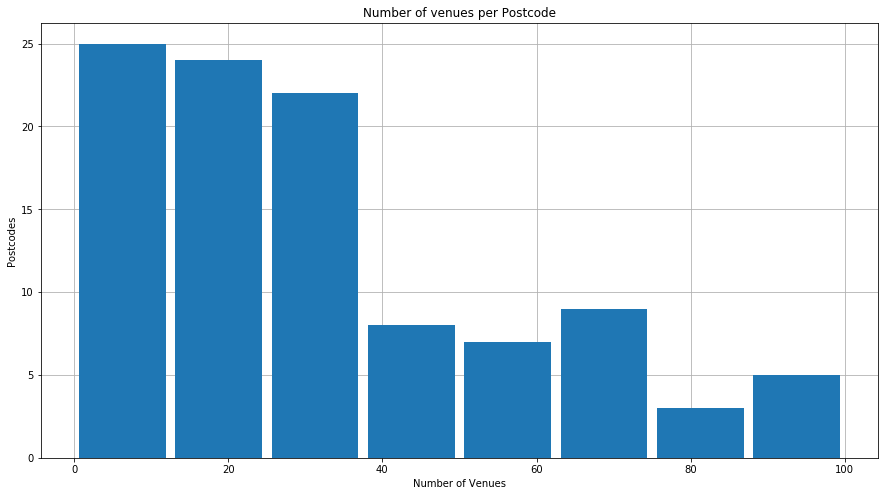

In [46]:
venues_in_postcode['# of Venues'].hist(bins=8, figsize=(15,8),zorder=2, rwidth=0.9)

plt.xlabel('Number of Venues')
plt.ylabel('Postcodes')
plt.title('Number of venues per Postcode')
plt.show()

##### Given that each postcode has a different radius passed to the venues request, it's better to represent the venues per postcode in terms of density.

In [47]:
density_venues_in_postcode = all_venues.groupby('Postcode').count()

density_venues_in_postcode = pd.DataFrame(list(zip(density_venues_in_postcode.index, density_venues_in_postcode['Venue'])), 
                                  columns=['Postcode', 'Density']).set_index('Postcode').join(dataframe_with_coordinates_df[['Postcode','Distance']].set_index('Postcode'), on='Postcode').reset_index()
density_venues_in_postcode['Density'] = np.int64(density_venues_in_postcode['Density']/(density_venues_in_postcode['Distance']/1000)) #distance in km
density_venues_in_postcode.loc[len(venues_in_postcode.index)] = ['M5E', 0, 111] #add M5E (postcode without venues) with zero as density

density_venues_in_postcode.head(10)

,Postcode,Density,Distance
0,M1B,21,1698.0
1,M1C,6,1625.0
2,M1E,21,1205.0
3,M1G,4,913.0
4,M1H,27,913.0
5,M1J,16,1301.0
6,M1K,21,1112.0
7,M1L,29,1052.0
8,M1M,17,1112.0
9,M1N,13,1297.0


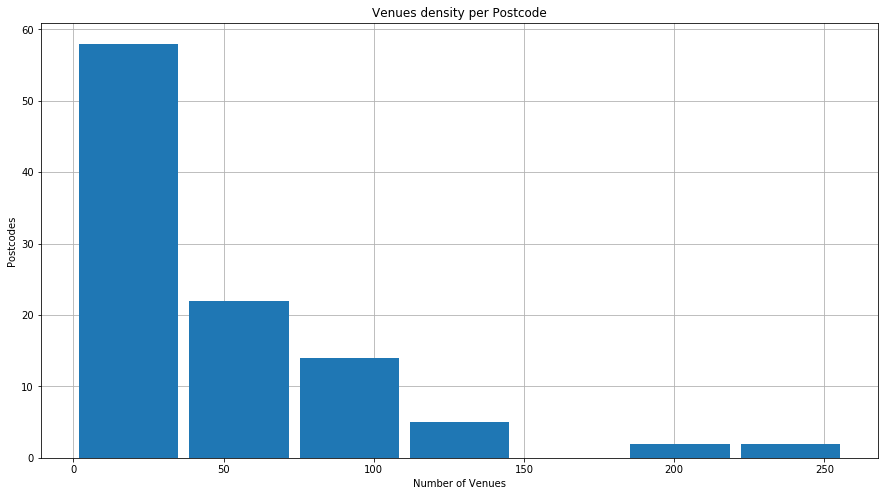

In [48]:
density_venues_in_postcode['Density'].hist(bins=7, figsize=(15,8),zorder=2, rwidth=0.9)

plt.xlabel('Number of Venues')
plt.ylabel('Postcodes')
plt.title('Venues density per Postcode')
plt.show()

##### The histogram above shows that Toronto has a low population density. 

#### 5. Cluster Neighborhoods

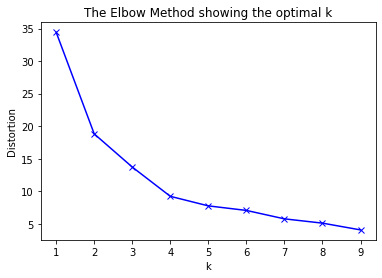

In [49]:
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 12)
    k_means.fit(density_venues_in_postcode['Density'].values.reshape(-1, 1))
    distortions.append(sum(np.min(cdist(density_venues_in_postcode['Density'].values.reshape(-1, 1),
                                        k_means.cluster_centers_, 'euclidean'), axis=1)) / density_venues_in_postcode['Density'].shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

##### Using the elbow method, the optimal value of the number of cluster was defined as 4.

In [50]:
num_clusters = 4

k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = 12)
k_means.fit(density_venues_in_postcode['Density'].values.reshape(-1, 1))
labels = k_means.labels_

print(labels)

[0 0 0 0 3 0 0 3 0 0 3 3 3 3 3 3 0 0 3 0 0 3 2 0 0 3 0 3 3 0 0 0 0 0 0 0 0
 2 2 3 3 2 3 2 0 0 3 2 0 2 0 2 1 2 1 2 2 2 1 2 2 3 0 0 3 3 1 3 3 2 3 3 0 0
 3 3 2 2 0 0 3 2 2 2 0 3 3 3 3 3 0 3 0 0 0 0 0 0 0 0 0 0 0]


In [51]:
density_venues_in_postcode['Cluster'] = k_means.labels_
density_venues_in_postcode.head(10)

,Postcode,Density,Distance,Cluster
0,M1B,21,1698.0,0
1,M1C,6,1625.0,0
2,M1E,21,1205.0,0
3,M1G,4,913.0,0
4,M1H,27,913.0,3
5,M1J,16,1301.0,0
6,M1K,21,1112.0,0
7,M1L,29,1052.0,3
8,M1M,17,1112.0,0
9,M1N,13,1297.0,0


#### 6.Examine Clusters

In [53]:
centroids = np.int64(round(density_venues_in_postcode.groupby('Cluster').mean()['Density']))
frecuency = density_venues_in_postcode.groupby('Cluster').count()['Postcode']

cluster_info = pd.DataFrame([np.arange(0,4), centroids, frecuency], index=['Cluster', 'Centroid','Postcodes']).T
cluster_info.sort_values('Centroid', inplace=True)
cluster_info.reset_index(drop=True, inplace=True)

cluster_info

,Cluster,Centroid,Postcodes
0,0,13,46
1,3,40,33
2,2,97,20
3,1,216,4


##### Based on the centroids of each cluster, the cluster names can be defined as:
1. '**Low Venues Density**': Centroid equal to 13
2. '**Medium-Low Venues Density**' with a centroid equal to 40
3. '**Medium-High Venues Density**' with a centroid equal to 97
4. '**High Venues Density**' with a centroid equal to 216

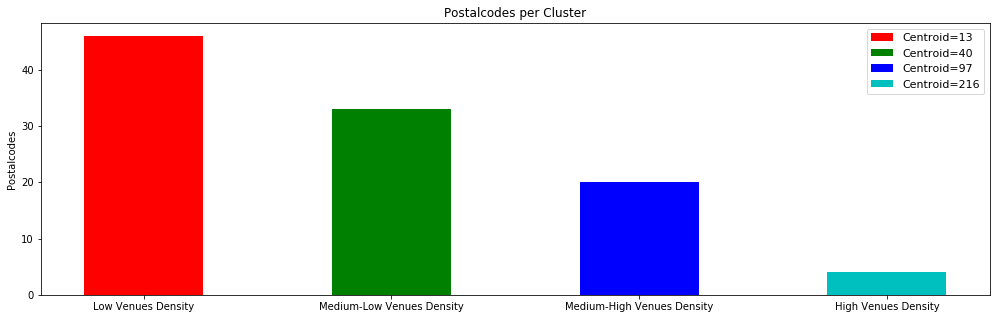

In [54]:
fig, ax = plt.subplots(figsize=(17,5))
clusters= ['Low Venues Density','Medium-Low Venues Density','Medium-High Venues Density','High Venues Density']
colors = ['r','g','b','c']
legend = []

for id, cluster in enumerate(clusters):
    legend.append('Centroid={}'.format(cluster_info['Centroid'][id]))
    bar = ax.bar(cluster, cluster_info['Postcodes'][id], 0.48, color=colors[id])

ax.set_ylabel('Postalcodes')
ax.set_title('Postalcodes per Cluster')
# ax.set_facecolor((1,1,1))
# ax.grid(True, axis='y',color='k', linestyle='-', linewidth=1)

plt.legend(legend, fontsize=11)

plt.show()

In [55]:
dataframe_with_coordinates_df = pd.concat([dataframe_with_coordinates_df[:56],dataframe_with_coordinates_df[57:],dataframe_with_coordinates_df[56:57]]) #move M5E to the last row
dataframe_with_coordinates_df['Cluster'] = k_means.labels_

colors = ['red','green','blue','cyan']
clusters_values = cluster_info['Cluster']

map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in dataframe_with_coordinates_df.itertuples(): #iterate each row of the dataframe
    cluster_index = clusters_values.index[clusters_values==location[-1]][0]
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}; {}'.format(location[1], location[2], location[3], clusters[cluster_index])
    label = folium.Popup(label, parse_html=True)    
    folium.Circle(
        radius=location[-2],
        popup=label,
        location=[location[-4], location[-3]],
        color=None,
        fill=True,
        fill_opacity=0.4,
        fill_color=colors[cluster_index]
    ).add_to(map) 

map

## ** This is the end of Part III and the whole NOTEBOOK **